In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm




In [ ]:
"""
   Description: 
    """

'\n   Description: \n    '

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
folder_path = Path('./system_analytics_2024/slurm_data')
file_path_parquet_reading = folder_path / 'slurm_data_cleaned.parquet.gzip'
df = pd.read_parquet(file_path_parquet_reading)
df.sample(n=10)


,job_id,Submit,Eligible,Start,End,Elapsed,Slurm_job_id,State,AllocCPUS,TotalCPU,AveRSS,MaxRSS,Number_of_nodes,node_id,node_type,job_run_time,job_waiting_time
1,7731848,2024-09-04 15:18:59,2024-09-04T15:18:59,2024-09-04 15:18:59,2024-09-04 15:20:10,00:01:11,7730866_159+,COMPLETED,32,07:11.227,507835K,507835K,1,fcn54,fcn,0 days 00:01:11,0 days 00:00:00
505,7826519,2024-09-13 13:15:41,2024-09-13T13:15:41,2024-09-13 13:15:41,2024-09-13 13:19:42,00:04:01,7826519_168+,COMPLETED,32,01:30:26,10708244K,10708244K,1,fcn72,fcn,0 days 00:04:01,0 days 00:00:00
1,8189491,2024-10-16 18:42:24,2024-10-16T18:42:24,2024-10-16 18:42:24,2024-10-16 22:42:34,04:00:10,8189491.bat+,CANCELLED,192,00:01.678,9339K,9339K,1,tcn783,tcn,0 days 04:00:10,0 days 00:00:00
0,5684020,2024-03-25 13:48:08,2024-03-25T13:48:08,2024-03-25 15:05:48,2024-03-25 15:07:51,00:02:03,5684020,FAILED,768,00:00:00,None,None,6,tcn168,tcn,0 days 00:02:03,0 days 01:17:40
0,6678347,2024-06-18 17:27:14,2024-06-18T17:27:14,2024-06-18 17:27:34,2024-06-18 17:28:12,00:00:38,6678347,FAILED,32,00:00:00,None,None,1,tcn48,tcn,0 days 00:00:38,0 days 00:00:20
2,8210141,2024-10-18 15:11:16,2024-10-18T15:11:16,2024-10-18 15:11:16,2024-10-18 15:12:30,00:01:14,8210141.ext+,COMPLETED,48,00:00.002,161K,161K,1,tcn1025,tcn,0 days 00:01:14,0 days 00:00:00
256,8252824,2024-10-24 04:16:51,2024-10-24T04:16:51,2024-10-24 04:16:51,2024-10-24 04:21:44,00:04:53,8252824.253,COMPLETED,192,13:51:49,35646592,42017K,1,tcn989,tcn,0 days 00:04:53,0 days 00:00:00
0,7454947,2024-08-12 14:50:04,2024-08-12T14:50:16,2024-08-12 15:31:47,2024-08-12 15:35:29,00:03:42,7452266_3263,COMPLETED,32,00:00:00,None,None,1,fcn32,fcn,0 days 00:03:42,0 days 00:41:43
2,8179023,2024-10-15 19:10:13,2024-10-15T19:10:13,2024-10-15 19:10:13,2024-10-15 19:12:46,00:02:33,8178992_31.+,COMPLETED,16,00:00.001,150K,150K,1,tcn306,tcn,0 days 00:02:33,0 days 00:00:00
2,7729892,2024-09-04 14:14:21,2024-09-04T14:14:21,2024-09-04 14:14:21,2024-09-04 14:16:16,00:01:55,7729409_144+,COMPLETED,32,00:00.001,148K,148K,1,fcn57,fcn,0 days 00:01:55,0 days 00:00:00


/tmp/ipykernel_2988308/2195974873.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = pd.DataFrame((df.groupby(['cat'])['State'].value_counts(normalize=True)))
/tmp/ipykernel_2988308/2195974873.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_stacked = df_temp.pivot_table(index='cat', columns='State')


<Axes: >

<Figure size 2000x600 with 0 Axes>

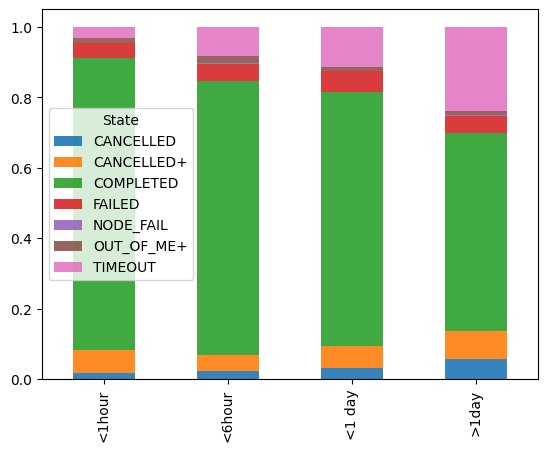

In [19]:


""" 
We analyse the status of a job based on its duration.
The interesting obeservation here is that for as the job duration
takes a longer time the channce of not completed increases. 
This has been obsereved before as well.

"""


time_for_cutting = [pd.Timedelta('5min'), 
                    pd.Timedelta('1h'), pd.Timedelta('6h'),
                     pd.Timedelta('1day'), pd.Timedelta('500day')]
labels = pd.cut(df['job_run_time'], bins=time_for_cutting, right=False)
df['cat'] = labels

# this is exactly the behavior that we want to show.
df_temp = pd.DataFrame((df.groupby(['cat'])['State'].value_counts(normalize=True)))
df_temp.reset_index(inplace=True)


df_stacked = df_temp.pivot_table(index='cat', columns='State')
df_stacked = df_stacked.droplevel(level=0, axis=1).copy()
df_stacked.index.name = ''
df_stacked.index = ['<1hour', '<6hour', '<1 day', '>1day']
plt.figure(figsize=(20, 6))
df_stacked.plot(kind='bar', stacked=True, alpha=0.9)


# sns.barplot(df_temp, x='cat', y='proportion', hue='State' )

In [20]:
"""
   Add features that you like here and then use them in the next block! 
    """

df['start_hour'] = df['Start'].dt.hour
df['start_day'] = df['Start'].dt.day
df['start_time_date'] = df['Start'].dt.date
df['start_time_day_name'] = df['Start'].dt.day_name()
df['start_time_week'] = df['Start'].dt.isocalendar().week
df['start_month'] = df['Start'].dt.month
df['start_quarter'] = pd.PeriodIndex(df['Start'], freq='Q')
df['start_year'] = df['Start'].dt.year



<Axes: xlabel='start_time_date', ylabel='Number_of_jobs_submitted'>

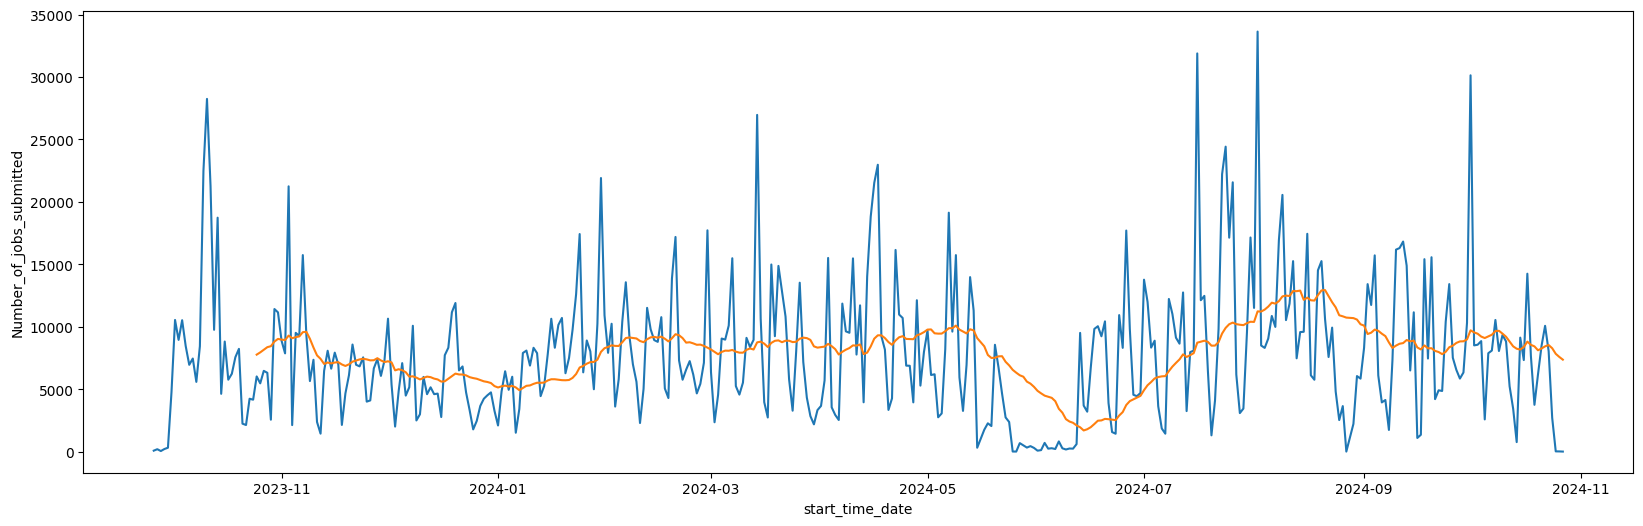

In [22]:
# get the daily numbers of the jobs


df_temp = (df.groupby(['start_time_date'])['job_id']
 .aggregate(['nunique']))

df_temp['moving_average'] = df_temp['nunique'].rolling(window=30).mean()

df_temp.reset_index(inplace=True)
df_temp.rename(columns={"nunique":"Number_of_jobs_submitted"}, inplace=True)

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_temp, x='start_time_date',
             y='Number_of_jobs_submitted'
             )
sns.lineplot(data=df_temp, x='start_time_date',
             y='moving_average'
             )

<Axes: xlabel='start_quarter', ylabel='Number_of_jobs_submitted'>

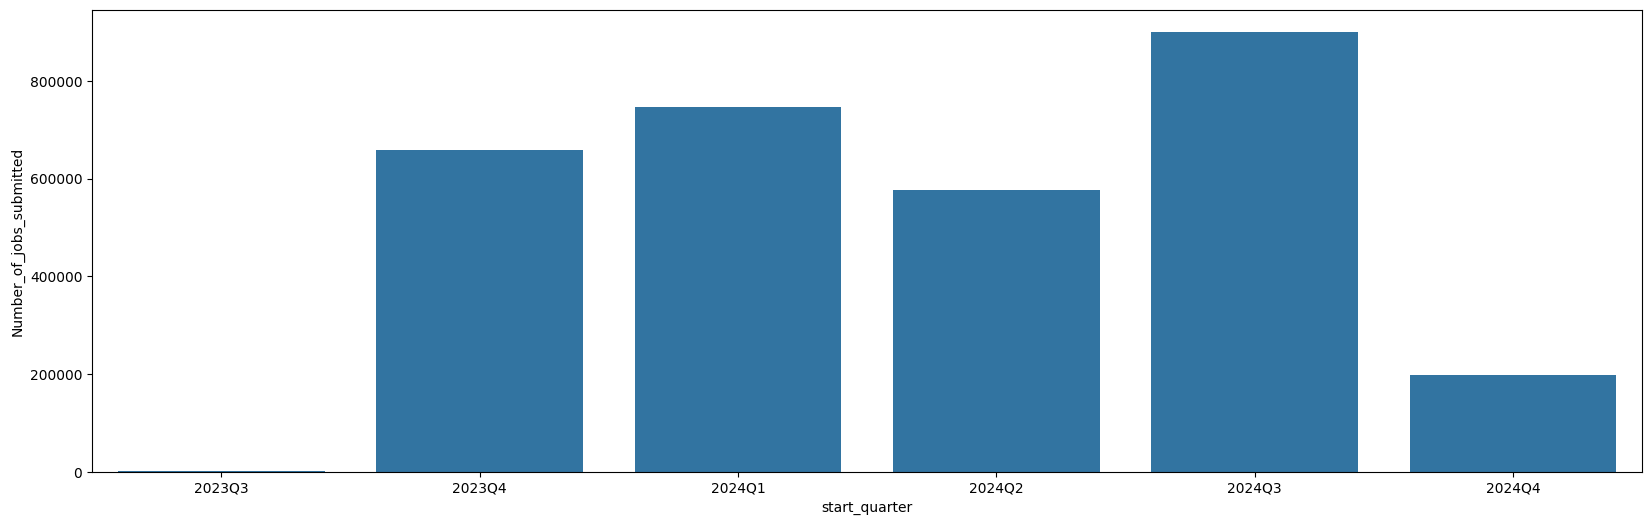

In [24]:
"""
    Observations: 
    1) In 2023Q3 we can see a sudden increase which can be explained by the introduction of the pahses in
    the HPC system.
    2) What happened in 2024Q2 is not clear since there is a sudden decrease in the the number of submiited jobs!
    """

df_temp = (df.groupby(['start_quarter'])['job_id']
 .aggregate(['nunique']))

df_temp.reset_index(inplace=True)
df_temp.rename(columns={"nunique":"Number_of_jobs_submitted"}, inplace=True)

plt.figure(figsize=(20, 6))
sns.barplot(df_temp, x='start_quarter', y='Number_of_jobs_submitted')


<Axes: xlabel='start_time_date', ylabel='Number_of_jobs_submitted'>

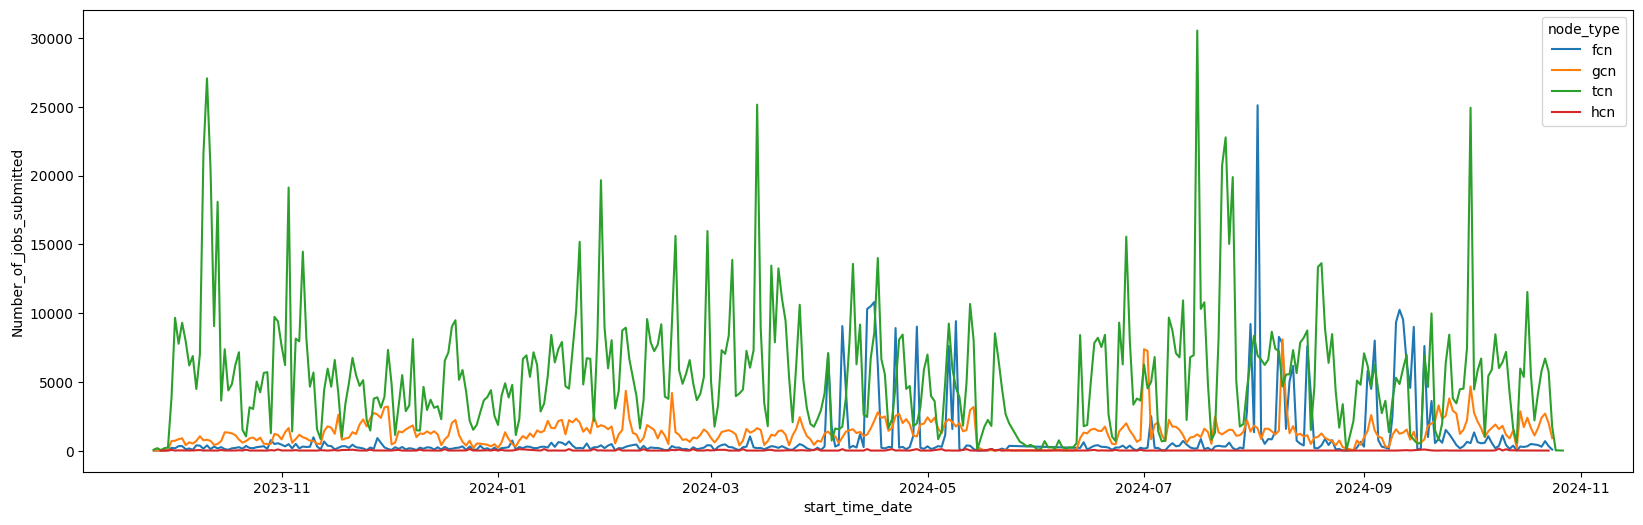

In [25]:

df_temp = (df.groupby(['start_time_date', 'node_type'])['job_id']
 .aggregate(['nunique']))

df_temp.reset_index(inplace=True)


df_temp.rename(columns={"nunique":"Number_of_jobs_submitted"}, inplace=True)


plt.figure(figsize=(20, 6))
sns.lineplot(data=df_temp, x='start_time_date',
             y='Number_of_jobs_submitted', hue='node_type'
             )

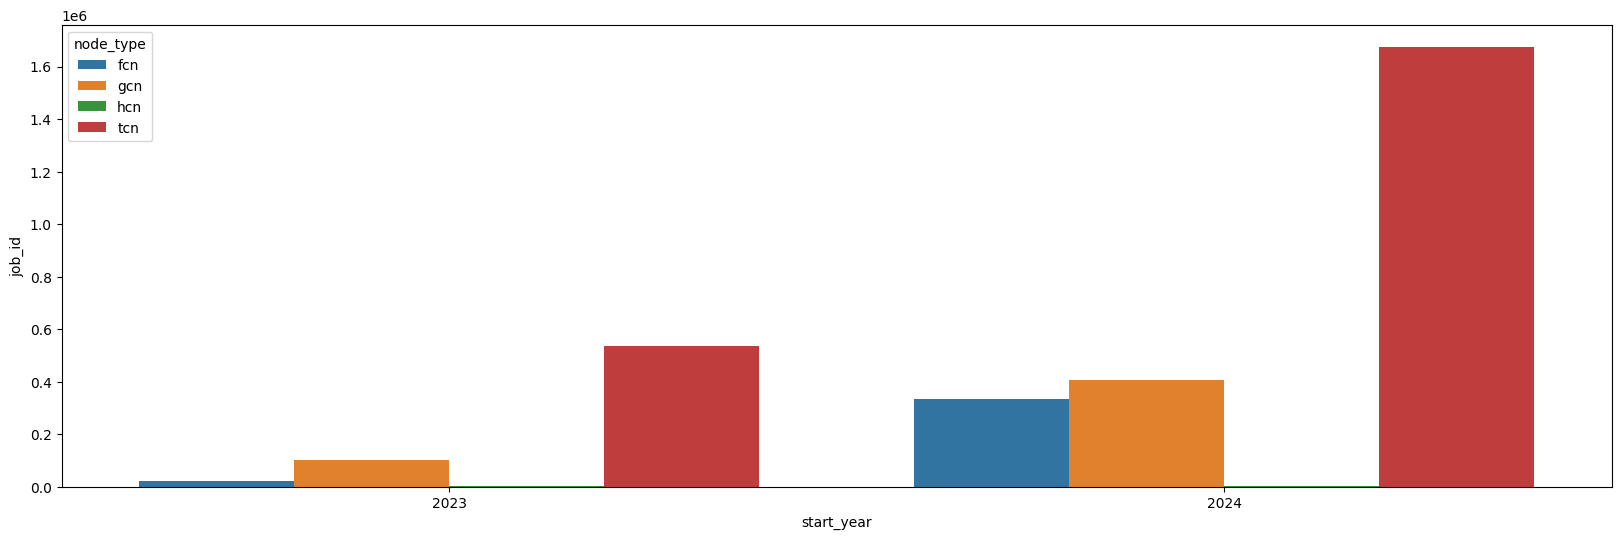

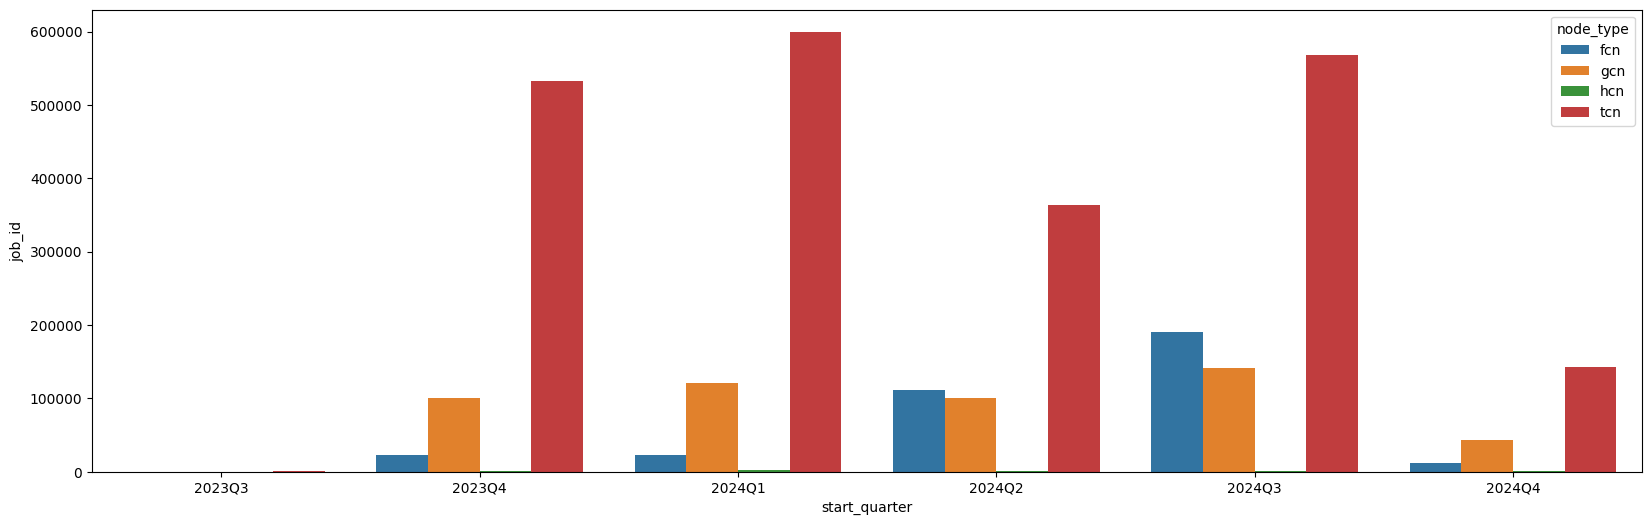

In [26]:
"""
   Observations: 1) Number of submitted jobs for fcn nodes has a sudden increase at 2024Q1!
    """


def fun_time(df, col_name):
    df_temp = (df.groupby(col_name)[['job_id']]
                      .nunique()
                      )
    df_temp.reset_index(inplace=True)
    plt.figure(figsize=(20, 6))
    # sns.pointplot(df_temp, x=col_name[0], y='job_id', hue=col_name[1])
    sns.barplot(df_temp, x=col_name[0], y='job_id', hue=col_name[1])
    # ax.set_axis_labels(f"{col_name[0]}", "total jobs")
    return None

fun_time(df, col_name=['start_year', 'node_type'])
# df_temp.head()
fun_time(df, col_name=['start_quarter', 'node_type'])
# fun_time(df, col_name=['job_start_time_day', 'node_type'])
# fun_time(df, col_name=['job_start_time_hour', 'node_type'])



In [10]:
"""
Number of nodes used per job: 
intersting to see that around 96 percents of the jobs use 1 node and around 1.5 percent use 2 nodes,
Others are not 
"""

df_temp = (df.groupby(['job_id'])['node_id']
 .aggregate(['nunique']))

df_temp.reset_index(inplace=True)
df_temp.rename(columns={"nunique":"Number_of_nodes"}, inplace=True)

# do another grouping this time based on the number of nodes

df_fin = (df_temp.groupby(['Number_of_nodes'])['job_id']
 .aggregate(['nunique'])
 .sort_values(('Number_of_nodes'), ascending=True))

df_fin.reset_index(inplace=True)
df_fin.rename(columns={"nunique":"Total_number_of_jobs"}, inplace=True)
df_fin['Percent_of_jobs'] = (100 * df_fin['Total_number_of_jobs']) / (df_fin['Total_number_of_jobs'].sum())
display(df_fin.head(n=6))

plt.figure(figsize=(20, 6))
sns.barplot(df_fin[1:20], x='Number_of_nodes', y='Percent_of_jobs')

'\nNumber of nodes used per job: \nintersting to see that around 96 percents of the jobs use 1 node and around 1.5 percent use 2 nodes,\nOthers are not \n'

In [11]:
"""
This figure shows the total number of jobs for the nodes (the top one).
Note that we are counting unique job.
Observations1: each gcn node is running more jobs than other nodes ==> this is expected to be the case
comapred to tcn nodes BUT not compared to fcn nodes. 
Obervation2: The data for tcn, gcn and fcn nodes are skewed, e.g, around 50 percent of gcn nodes
do not run as many jobs as their peer groups. 

    """
# df_temp = (df.groupby(['node_id'])[['job_id']]
#                       .nunique().
#                       sort_values('job_id', ascending=False))
# df_temp.reset_index(inplace=True)
# df_temp.rename(columns={"job_id":"Number_of_jobs"}, inplace=True)
# df_fin = pd.merge(df_temp, df[['node_id', 'node_type']].drop_duplicates(), on='node_id')
# display(df_fin.head(n=5))
# plt.figure(figsize=(20, 6))
# sns.boxplot(df_fin, x='Number_of_jobs', y='node_type', showmeans=True,
#             meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})

# # the last 100 nodes in terms of number of jobs!
# df_nodes_min_jobs = df_fin.tail(n=25).copy()


'\nThis figure shows the total number of jobs for the nodes (the top one).\nNote that we are counting unique job.\nObservations1: each gcn node is running more jobs than other nodes ==> this is expected to be the case\ncomapred to tcn nodes BUT not compared to fcn nodes. \nObervation2: The data for tcn, gcn and fcn nodes are skewed, e.g, around 50 percent of gcn nodes\ndo not run as many jobs as their peer groups. \n\n    '

In [12]:
# can we see the 80 percent thing here?
# like 80 percent of the jobs in each node_type are done by 20 percent of the nodes?
# Also if we focus on the jobs in 2024 that would be better bacause
# they were adding nodes

# plt.figure(figsize=(20, 6))
# sns.pointplot(df_fin.iloc[-20:], x='node_id', y='Number_of_jobs', hue='node_type')


In [13]:
"""
We are interested in the statitstics for job-step durations for the nodes.
Particularly, as the previous analysis showed some of the nodes do not run as many jobs as other nodes.
We show the maximum run time that a  node in its life time through a job has achieved so far.
Observation1: As we can see for tcn and gcn nodes in many cases they have reached the maximum walltime
which is 120, though there are some outliers we check them later.
We show the nodes that have not woked that long, this is especially intersting for gcn nodes, it seems that
a few of them have maxtime lower than 6 hours!
"""

# duration in hour
# df['job_step_duration_hour'] = (df['end_time'] - df['start_time'])/pd.Timedelta('1 hour')
# # df['time'].dt.floor('1d')
# df_temp = (df.groupby(['node_id'])[['job_step_duration_hour']]
#                     .aggregate('max')
#                     .sort_values('job_step_duration_hour', ascending=False)
#                     )
# df_temp.reset_index(inplace=True)


# df_fin = pd.merge(df_temp, df[['node_id', 'node_type']].drop_duplicates(), on='node_id')
# display(df_fin.head(n=5))
# plt.figure(figsize=(20, 6))
# g= sns.boxplot(df_fin, x='job_step_duration_hour', y='node_type', showmeans=True,
#             meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})
# g.set_xlim(left=0, right=200)

# # the last 100 nodes in terms of number of jobs!
# df_nodes_min_hours = df_fin.tail(n=25).copy()

'\nWe are interested in the statitstics for job-step durations for the nodes.\nParticularly, as the previous analysis showed some of the nodes do not run as many jobs as other nodes.\nWe show the maximum run time that a  node in its life time through a job has achieved so far.\nObservation1: As we can see for tcn and gcn nodes in many cases they have reached the maximum walltime\nwhich is 120, though there are some outliers we check them later.\nWe show the nodes that have not woked that long, this is especially intersting for gcn nodes, it seems that\na few of them have maxtime lower than 6 hours!\n'

In [14]:
"""
We show the maximum run time for the nodes ranked from smallest value.
It is intersting perhaps expected that many of these nodes are gcn nodes.
Also it is a nice coincidence that gcn115 has the feweset jobs and also shortest max time!
"""


# plt.figure(figsize=(20, 6))
# sns.pointplot(df_fin.iloc[-15:], x='node_id', y='job_step_duration_hour', hue='node_type')


'\nWe show the maximum run time for the nodes ranked from smallest value.\nIt is intersting perhaps expected that many of these nodes are gcn nodes.\nAlso it is a nice coincidence that gcn115 has the feweset jobs and also shortest max time!\n'

In [15]:
# create a plot for 2024 and show the mean of the hours that a node has worked.
# beacause it seems that some of the gcn nodes are doing shorter jobs!
# this becomes clear later when we find out that almost all gcn nodes have the same 
# waiting time!



In [16]:


""" We would like to find the node waiting time, meaning how long does it take for
a node to be called for doing the next job or step in a job?
This is the closest signal to IDLE mode(?) we can have.

"""

# df_temp= df[['job_id','step_id','node_id', 'start_time_sec', 'node_type']].copy()
# df_temp.sort_values(by=['node_id', 'start_time_sec'], inplace=True)





# group_list = []
# for name, group in tqdm(df_temp.groupby('node_id')):
#     # shift the start for this node and get the difference with start
#     group['node_waiting_time']= group['start_time_sec'].shift(-1) - group['start_time_sec']
#     group['node_waiting_time_minute'] = (group['node_waiting_time'])/60
#     # find the upper and lowere quantile since these because of maintenance 
#     # a node can wait too long for the next job!
#     upper_bound = group[['node_waiting_time']].quantile(q=0.95, numeric_only=True)
#     lowerbound = group[['node_waiting_time']].quantile(q=0.01, numeric_only=True)
#     group['node_waiting_time'] = (group[['node_waiting_time']]
#                                             .clip(lower=lowerbound, upper=upper_bound, axis=1))

#     group_list.append(group)
    

# # put all of them together
# df_waiting_time = pd.concat(group_list, ignore_index=True).copy()


' We would like to find the node waiting time, meaning how long does it take for\na node to be called for doing the next job or step in a job?\nThis is the closest signal to IDLE mode(?) we can have.\n\n'

In [17]:
"""
    We can observe that gcn nodes need to wait longer to get a job.
    We further look at some samples in each category.
    """

# fig, ax = plt.subplots(figsize=(20, 6))
# sns.ecdfplot(df_waiting_time, x='node_waiting_time_minute', hue='node_type',
#              log_scale=True, ax=ax)
# ax.grid()

'\n    We can observe that gcn nodes need to wait longer to get a job.\n    We further look at some samples in each category.\n    '

In [18]:
"""
    Two observations:
    1) gcn nodes are very close to each other in terms of waiting while this is not the case for fcn and tcn nodes,
    meaning some of them have to wait for longer periods of time to get a job.
    2) As we saw before, some of the gcn nodes have very low run time hour compared to others, here we see that
    It is not the case that they have to 
    
    """


# def ecdf_plot(node_type):
#     df_temp = df_waiting_time[df_waiting_time['node_type']==node_type].copy()
#     # to get 10 unique random node id!
#     random_node_id = pd.Series(df_temp['node_id'].unique()).sample(32) 
#     df_temp = df_temp[df_temp['node_id'].isin(random_node_id)].copy()
#     fig, ax = plt.subplots(figsize=(20, 6))
#     sns.ecdfplot(df_temp, x='node_waiting_time', hue='node_id',
#                 log_scale=True, ax=ax)
#     ax.grid()

# ecdf_plot('gcn')
# ecdf_plot('fcn')
# ecdf_plot('tcn')


'\n    Two observations:\n    1) gcn nodes are very close to each other in terms of waiting while this is not the case for fcn and tcn nodes,\n    meaning some of them have to wait for longer periods of time to get a job.\n    2) As we saw before, some of the gcn nodes have very low run time hour compared to others, here we see that\n    It is not the case that they have to \n    \n    '